In [1]:
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

## Define Constants

In [2]:
RW_STEP_SIZE: int = 250

# Define Loading Pipeline

In [3]:
def get_paths_to_data(dir: str = "../data/raw/P01", append_path: bool = True) -> list:
    # Get list of csv files
    data_paths = os.listdir(dir)
    # Keep only csv data
    data_paths = [x for x in data_paths if x.endswith(".csv")]
    # Append path from current dir to csv file if input param is True
    if append_path:
        data_paths = [os.path.join(dir, x) for x in data_paths]
    return data_paths

def load_data(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    # Convert 'TS_UNIX' to datetime
    df["TS_UNIX"] = pd.to_datetime(df["TS_UNIX"], format="%Y-%m-%d %H:%M:%S.%f")
    return df

def filter_condition_from_df(df: pd.DataFrame, condition: str) -> pd.DataFrame:
    df = df[df["Condition"] == condition]
    return df

def apply_rolling_window(df: pd.DataFrame, feat: str, step: int = 250) -> pd.DataFrame:
    # Apply rolling window with step size step on column feat
    df[f"{feat}-RW{step}"] = df[feat].rolling(window=step).mean()
    return df

def remove_nan_rows(df: pd.DataFrame, col_to_inspect: str) -> pd.DataFrame:
    df = df[df[col_to_inspect].notna()]
    return df

def get_eeg_cols(df: pd.DataFrame, search_str: str = "EEG") -> list[str]:
    return [x for x in list(df.columns) if x.startswith(search_str)]


# Execute Loading Pipeline

In [4]:
data_paths = get_paths_to_data()    # Get paths to all csv files
data_paths.sort()   # Sort them alphabetically

In [5]:
# Do Loading Pipeline for every recording csv file and save data in df_list
df_list = []
for path in data_paths:
    df = load_data(path)
    df = filter_condition_from_df(df, condition="MathxHard")
    for col in get_eeg_cols(df):
        df = apply_rolling_window(df, feat=col, step=RW_STEP_SIZE)
    df = remove_nan_rows(df, col_to_inspect=f"EEG-L3-RW{RW_STEP_SIZE}")
    df_list.append(df)


# Visualize

Saving figure in '../assets/all_sessions.png'


/var/folders/h0/sqy12xn11_gg038734m010lh0000gn/T/ipykernel_37668/1691411424.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


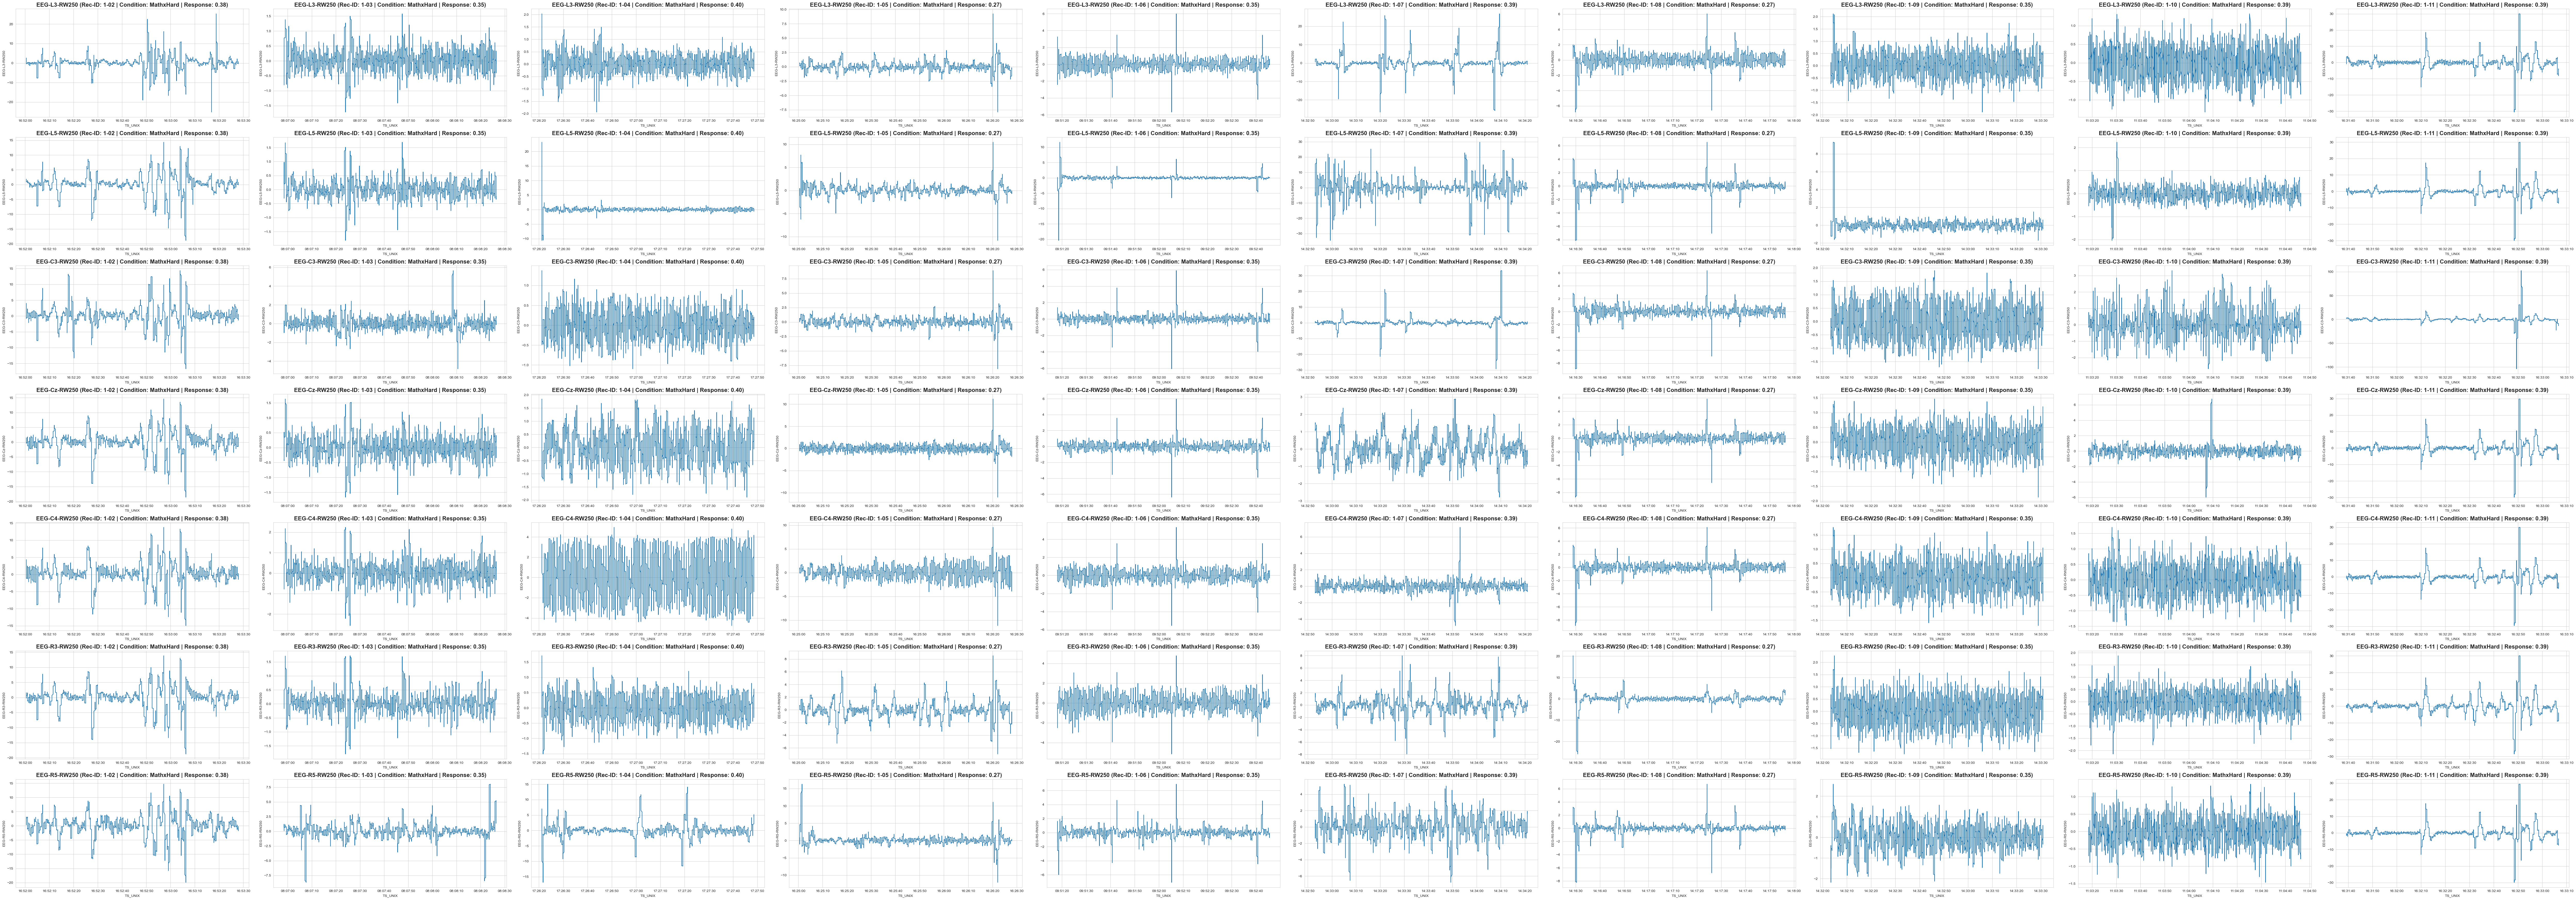

In [6]:
def plot_all_time_series(df: pd.DataFrame, time_col: str = "TS_UNIX") -> None:
    """ Plots all Time Series (all float64 columns) in the provided DataFrame

    :param df: pd.DataFrame -- Input DataFrame
    :param time_col: str -- Name of the time column
    :return: None
    """
    cols = [x for x in list(df.columns) if x.endswith(f"RW{RW_STEP_SIZE}")]
    condition = df["Condition"].iloc[0]
    response = df["Response"].iloc[0]

    fig, axes = plt.subplots(nrows=len(cols), ncols=1, figsize=(20, len(cols)*5))
    for col, ax in zip(cols, axes.flatten()):
        sns.lineplot(data=df, x=time_col, y=col, ax=ax,)
        ax.set_title(col + f" (Condition: {condition} | Response: {response:.2f})", fontweight="bold", size=16)
    fig.tight_layout()
    fig.show()


def plot_all_time_series_all_sessions(df_list: list[pd.DataFrame], time_col: str = "TS_UNIX", savefig: bool = True) -> None:
    """ Plots all Time Series (all float64 columns) in the provided list of DataFrame

    :param df_list: list[pd.DataFrame] -- List of input DataFrames
    :param time_col: str -- Name of the time column
    :param savefig: bool -- Whether to save it in root/assets or not
    :return: None
    """
    cols = [x for x in list(df_list[0].columns) if x.endswith(f"RW{RW_STEP_SIZE}")]

    fig, axes = plt.subplots(nrows=len(cols), ncols=len(df_list), figsize=(len(df_list)*10, len(cols)*5))
    for j, df in enumerate(df_list):
        condition = df["Condition"].iloc[0]
        response = df["Response"].iloc[0]
        session = df["RecID"].iloc[0]
        for i, col in enumerate(cols):
            sns.lineplot(data=df, x=time_col, y=col, ax=axes[i, j])
            axes[i, j].set_title(col + f" (Rec-ID: {session} | Condition: {condition} | Response: {response:.2f})", fontweight="bold", size=16)
    fig.tight_layout()

    if savefig:
        path = "../assets/all_sessions.png"
        print(f"Saving figure in '{path}'")
        plt.savefig(path)

    fig.show()


# Plot for one session
#plot_all_time_series(df)

# Plot for all Session
plot_all_time_series_all_sessions(df_list)

In [7]:
df.head(5)

,token,RecID,Condition,EEG-L3,EEG-L5,EEG-C3,EEG-Cz,EEG-C4,EEG-R3,EEG-R5,TS_UNIX,Response,EEG-L3-RW250,EEG-L5-RW250,EEG-C3-RW250,EEG-Cz-RW250,EEG-C4-RW250,EEG-R3-RW250,EEG-R5-RW250
56525,tit0Ke,1-11,MathxHard,20.870639,11.641672,3.461614,-3.062109,2.864160,11.342918,7.529772,2022-06-27 16:31:39.282195968+02:00,0.390909,-0.891914,0.280378,1.853403,0.156984,0.034852,-0.909730,-0.463172
56526,tit0Ke,1-11,MathxHard,23.754610,13.792090,0.119193,-1.781448,2.044575,12.722723,6.241704,2022-06-27 16:31:39.282208+02:00,0.390909,-0.681256,0.446288,1.986537,0.315634,0.204658,-0.761060,-0.389278
56527,tit0Ke,1-11,MathxHard,16.733636,8.894985,-10.292314,-8.345529,-6.129241,5.987096,-1.447466,2022-06-27 16:31:39.282221824+02:00,0.390909,-0.501148,0.597149,2.058992,0.434501,0.319494,-0.638227,-0.350411
56528,tit0Ke,1-11,MathxHard,7.790066,2.623710,-20.332449,-15.470753,-14.027972,-1.712840,-7.688919,2022-06-27 16:31:39.282234880+02:00,0.390909,-0.399071,0.703602,2.051845,0.476132,0.348037,-0.576424,-0.369533
56529,tit0Ke,1-11,MathxHard,4.305861,0.279688,-23.604498,-16.590771,-15.082496,-4.124776,-6.909858,2022-06-27 16:31:39.282247168+02:00,0.390909,-0.386049,0.756301,1.974326,0.434121,0.292290,-0.582977,-0.446670
